### **Imports**

In [1]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
# from scipy.sparse import random
# from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# from sklearn.model_selection import train_test_split
# import geopandas as gpd
# import shapely
# import shapely.wkt
from geomet import wkt

In [2]:
dfCapi= pd.read_csv("parte2.csv")
barrios=pd.read_csv("barrios.csv")

**- Limpieza de la columna price_usd_per_m2 y Estimar m2 con la columna Property_type y Place Name (Barrio)**

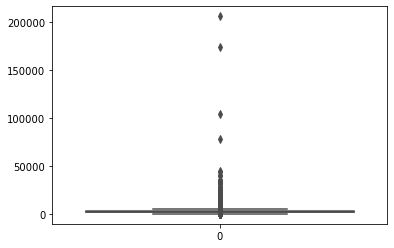

In [3]:
#Hacemos un boxplot para ver la distribución de la columna P x m2
sns.boxplot(data=dfCapi['price_usd_per_m2'], color = 'r');

In [4]:
dfCapi['price_usd_per_m2'][dfCapi['price_usd_per_m2']<=100] = np.NaN

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_2252/3945242645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCapi['price_usd_per_m2'][dfCapi['price_usd_per_m2']<=100] = np.NaN


In [5]:
#como hay outliers calculamos el rango intercuartil para excluirlos en el análisis 
q1 = dfCapi['price_usd_per_m2'].quantile(0.25)
q2 = dfCapi['price_usd_per_m2'].quantile(0.5)
q3 = dfCapi['price_usd_per_m2'].quantile(0.75)
q4 = dfCapi['price_usd_per_m2'].quantile(1)

riq = q3-q1
lim_inf = q1-1.5*riq
lim_sup = q3+1.5*riq
print(lim_inf," ",lim_sup)


263.7941111715893   4780.401084317455


In [6]:
#Creo columna auxiliar para completar sin outiler ni nulos para preservar los valores originales 
dfCapi["price_m2_sin_out"] = dfCapi.price_usd_per_m2
dfCapi['price_m2_sin_out'][(dfCapi['price_m2_sin_out'] < lim_inf) | (dfCapi['price_m2_sin_out'] > lim_sup)] = np.NaN # reemplazos los outliers por nulls

C:\Users\ARIEL~1.DAP\AppData\Local\Temp/ipykernel_2252/3581739041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCapi['price_m2_sin_out'][(dfCapi['price_m2_sin_out'] < lim_inf) | (dfCapi['price_m2_sin_out'] > lim_sup)] = np.NaN # reemplazos los outliers por nulls


In [7]:
#Filtro los datos sin outliers para trabajar con ellos
price_m2_sin_out = dfCapi['price_usd_per_m2'][(dfCapi['price_usd_per_m2'] >= lim_inf) & ((dfCapi['price_usd_per_m2'] <= lim_sup))]
price_m2_sin_out

0        1127.272727
1        1309.090909
3        3066.666667
4        3000.000000
5        2234.000000
            ...     
29733    3368.421053
29734    3750.000000
29735    2611.464968
29737    2858.695652
29738    1675.324675
Name: price_usd_per_m2, Length: 20379, dtype: float64

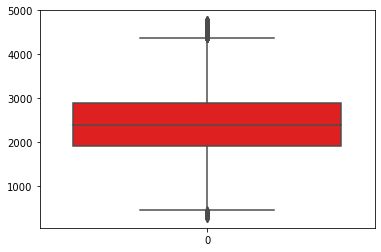

In [8]:
#chequeamos graf. con un boxplot de nuevo
sns.boxplot(data=price_m2_sin_out, color = 'r');

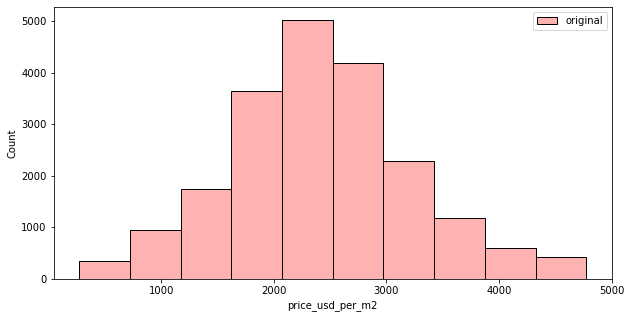

In [9]:
#histograma de la columna sin outliers y mayores a usd 100
fig = plt.figure(figsize=(10,5));ax=plt.axes()
sns.histplot(price_m2_sin_out, color = 'r',bins=10, alpha=0.3)
ax.legend(labels = ['original'])

In [10]:
#Observamos que en al nueva columna hay nulos originales mas los aplicados a los outliers
dfCapi['price_m2_sin_out'].isnull().sum()

9360

Reemplazo de valores nulos de campo price_usd_per_m2

In [18]:
#tenemos que ver como se completan los datos nulos. Proponemos asignar la media agrupada por tipo de propiedad y por barrio 
dfCapi_grouped = dfCapi.groupby(["place_name",'property_type'])['price_m2_sin_out']
price_usd_per_m2_por_tipo_prop = dfCapi_grouped.transform(lambda x : x.fillna(x.mean()))

In [19]:
#Analizamos media, mediana y moda de las dos columnas
print('La media original es:',round(dfCapi['price_usd_per_m2'].mean(),2))
print('La moda original es:', round(dfCapi['price_usd_per_m2'].mode()[0],2))
print('La mediana original es:',round (dfCapi['price_usd_per_m2'].median(),2))

print('La media completada por tipo de propiedad es:', round(price_usd_per_m2_por_tipo_prop.mean(), 2)) 
print('La moda completada por tipo de propiedad es:', round(price_usd_per_m2_por_tipo_prop.mode()[0],2))
print('La mediana completada por tipo de propiedad es:', round(price_usd_per_m2_por_tipo_prop.median(),2))

La media original es: 3119.68
La moda original es: 2500.0
La mediana original es: 2468.49
La media completada por tipo de propiedad es: 2437.15
La moda completada por tipo de propiedad es: 3065.59
La mediana completada por tipo de propiedad es: 2388.89


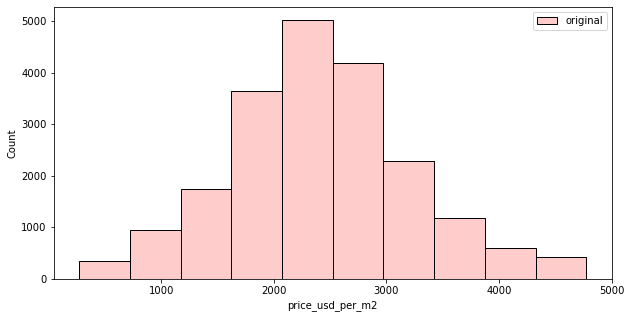

In [20]:
fig = plt.figure(figsize=(10,5));ax=plt.axes()

sns.histplot(price_m2_sin_out, color = 'r',bins=10,alpha=0.2,)
#sns.histplot(price_usd_per_m2_por_tipo_prop[(price_usd_per_m2_por_tipo_prop < lim_sup) & (price_usd_per_m2_por_tipo_prop > 100)], color = 'g',bins=10,alpha=0.2)


ax.legend(labels=['original', 'per-type']);

In [21]:
#reemplazo valores
dfCapi['price_m2_sin_out'] = price_usd_per_m2_por_tipo_prop

In [22]:
dfCapi['price_m2_sin_out'].isnull().sum()

6

**- Rooms, price y superficie: eliminación de outliers**

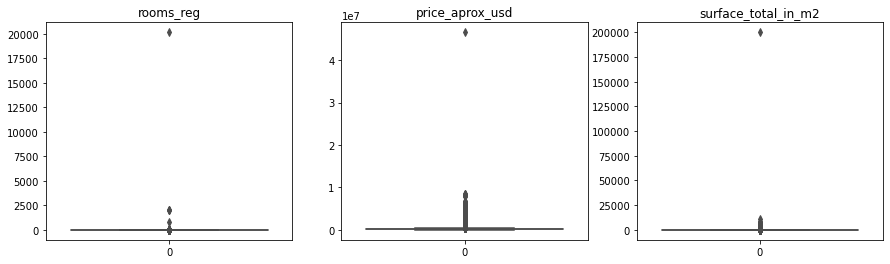

In [23]:
fig = plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('rooms_reg')
sns.boxplot(data=dfCapi['rooms_reg'], color = 'r');

plt.subplot(132)
plt.title('price_aprox_usd')
sns.boxplot(data=dfCapi['price_aprox_usd'], color = 'r');

plt.subplot(133)
plt.title('surface_total_in_m2')
sns.boxplot(data=dfCapi['surface_total_in_m2'], color = 'r');


In [31]:
#Eliminamos outliers de rooms

q1 = dfCapi['rooms_reg'].quantile(0.25)
q3 = dfCapi['rooms_reg'].quantile(0.75)

riq = q3-q1
lim_inf = q1-1.5*riq # -2
lim_sup = q3+1.5*riq # 6

dfCapi= dfCapi[(dfCapi.rooms_reg.isnull()) | (dfCapi['rooms_reg'] < lim_sup)]

In [32]:

q1 = dfCapi['price_aprox_usd'].quantile(0.25)
q3 = dfCapi['price_aprox_usd'].quantile(0.75)

riq = q3-q1
lim_sup = q3+1.5*riq # 6

In [33]:
#Eliminamos outliers de price_aprox_usd

q1 = dfCapi['price_aprox_usd'].quantile(0.25)
q3 = dfCapi['price_aprox_usd'].quantile(0.75)

riq = q3-q1
lim_inf = q1-1.5*riq # -2
lim_sup = q3+1.5*riq # 6

dfCapi= dfCapi[(dfCapi.price_aprox_usd.isnull()) | (dfCapi['price_aprox_usd'] < lim_sup)]

In [34]:
#Eliminamos outliers de surface_total_in_m2

q1 = dfCapi['surface_total_in_m2'].quantile(0.25)
q3 = dfCapi['surface_total_in_m2'].quantile(0.75)

riq = q3-q1
lim_inf = q1-1.5*riq # -2
lim_sup = q3+1.5*riq # 6

dfCapi= dfCapi[(dfCapi.surface_total_in_m2.isnull()) | (dfCapi['surface_total_in_m2'] < lim_sup)]

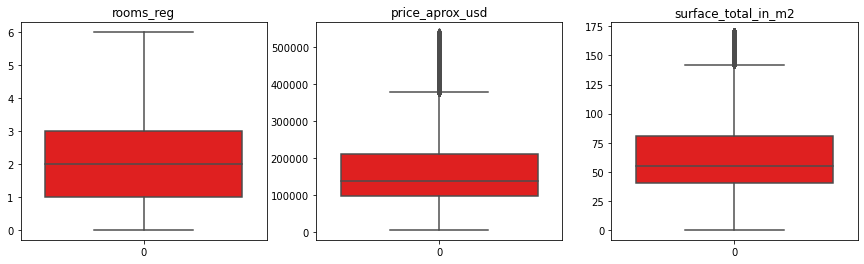

In [35]:
fig = plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('rooms_reg')
sns.boxplot(data=dfCapi['rooms_reg'], color = 'r');

plt.subplot(132)
plt.title('price_aprox_usd')
sns.boxplot(data=dfCapi['price_aprox_usd'], color = 'r');

plt.subplot(133)
plt.title('surface_total_in_m2')
sns.boxplot(data=dfCapi['surface_total_in_m2'], color = 'r');


In [36]:
dfCapi["cerca_lejos"] = dfCapi.apply(lambda x: 1 if x.distancia_subte < 400 else 0, axis=1)

### **2. Análisis descriptivo y relaciones entre variables**

**- Relación Barrio y precio en usd por m2**

Hacemos un mapa de calor con la media de price_usd_per_m2 sin outliers por barrio y comparamos con su versión con outliers 

In [37]:
#Volvemos a tirar el df agrupado con los promedios de las variables cuanti para usar despues en el mapa de calor 
dfCapi_grouped=dfCapi.groupby('place_name').mean()
dfCapi_grouped

Unnamed: 0  Unnamed: 0.1  geonames_id        lat  \
place_name                                                             
abasto            13719.411111  55342.488889          NaN -34.603485   
agronomía         12601.257143  50442.371429    3436487.0 -34.592948   
almagro           13929.793996  56072.490683    3436397.0 -34.607811   
balvanera         14490.389456  58583.680272    6693228.0 -34.609690   
barracas          12121.279412  49432.217647    3436134.0 -34.637625   
...                        ...           ...          ...        ...   
villa real        13713.300000  55475.400000    3427383.0 -34.620540   
villa riachuelo   15147.750000  61506.500000    3427379.0 -34.694169   
villa santa rita   9619.333333  39125.833333    6693230.0 -34.614999   
villa soldati     11661.545455  47026.454545    3427366.0 -34.663861   
villa urquiza     18084.692762  72873.478582    3433775.0 -34.573035   

                        lon          price  price_aprox_local_currency  \
place_name                                                               
abasto           -58.411373  148937.823529                2.321483e+06   
agronomía        -58.485178  143499.218750                2.531972e+06   
almagro          -58.421548  195875.803550                2.431744e+06   
balvanera        -58.402668  134247.283662                2.187920e+06   
barracas         -58.374295  156919.921687                2.661545e+06   
...                     ...            ...                         ...   
villa real       -58.524496  157433.333333                2.777832e+06   
villa riachuelo  -58.469231  150000.000000                2.646675e+06   
villa santa rita -58.479813  140373.404255                2.476819e+06   
villa soldati    -58.449806  169090.909091                1.484581e+06   
villa urquiza    -58.482783  464305.118464                2.821769e+06   

                  price_aprox_usd  surface_total_in_m2  surface_covered_in_m2  \
place_name                                                                      
abasto              131569.763176            64.229730              55.385542   
agronomía           143499.218750            62.652174              59.121212   
almagro             137818.783325            61.803218              63.963402   
balvanera           124000.114470            66.689815              69.731978   
barracas            150842.749548            75.652921              71.294118   
...                           ...                  ...                    ...   
villa real          157433.333333           102.250000              76.933333   
villa riachuelo     150000.000000           136.000000              74.000000   
villa santa rita    140373.404255            64.000000              47.847826   
villa soldati        84138.440000            92.000000              82.636364   
villa urquiza       159923.428235            62.536339              56.676560   

                  price_usd_per_m2  price_per_m2      floor     rooms  \
place_name                                                              
abasto                 2111.851015   2640.677763   5.142857  2.600000   
agronomía              2199.055108   2838.127186  17.500000  2.535714   
almagro                2260.444044   4144.444355   4.361702  2.436893   
balvanera              1970.019933   2465.076716   5.947368  2.705426   
barracas               2048.310106   2405.006445  15.043478  2.738693   
...                            ...           ...        ...       ...   
villa real             1628.583875   2161.857633        NaN  3.200000   
villa riachuelo        1281.420765   3318.181818  12.000000  3.500000   
villa santa rita       2038.422164  30757.653668   5.700000  2.472222   
villa soldati          1076.242863   2464.039446   4.666667  3.727273   
villa urquiza          2526.581012   8747.966607  44.115044  2.230143   

                     expenses  rooms_reg  distancia_subte  price_m2_sin_out  \
place_name                           

In [38]:
# Ahora volvemos a hacer el match entre barrios y dfCapi1_grouped. Vamos a armar dos columnas:
# 1) usdm2 que va a tener la media de price_usd_per_m2 por barrio
# 2) usdm2_sin_out lo mismo pero con la columna sin outliers
#Si no printea ningun barrio es porque matcheo todo

In [39]:
usdm2=[]
for i,x in barrios.iterrows():
    try:
        j=dfCapi_grouped.index.get_loc(x.barrio)
        usdm2.append(dfCapi_grouped.iloc[j].price_usd_per_m2) # le appedeamos el price usd por m2 de dfCapi_grouped promedio a pm2. Si no lo encuentra le pone 0
    except:
        # printeo los que no encuentra
        print(x.barrio)
        usdm2.append(0)

In [40]:
usdm2_sin_out=[]
for i,x in barrios.iterrows():
    try:
        j=dfCapi_grouped.index.get_loc(x.barrio)
        usdm2_sin_out.append(dfCapi_grouped.iloc[j].price_m2_sin_out) # le appedeamos el price usd por m2 de dfCapi_grouped promedio a pm2. Si no lo encuentra le pone 0
    except:
        # printeo los que no encuentra
        (x.barrio)
        usdm2_sin_out.append(0)

In [41]:
# Sumamos estas listas al df de barrios para hacer los mapas de calor 
barrios['price_usd_per_m2']=usdm2
barrios['price_usd_per_m2_sin_out']=usdm2_sin_out
barrios.head(5)

Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                                                 WKT            barrio  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         chacarita   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          paternal   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      villa crespo   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  villa del parque   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           almagro   

   COMUNA    PERIMETRO          AREA  \
0    15.0  7725.695228  3.118101e+06   
1    15.0  7087.513295  2.229829e+06   
2    15.0  8132.699348  3.613584e+06   
3    11.0  7705.389797  3.399596e+06   
4     5.0  8537.901368  4.050752e+06   

                                         WKT_shapely  price_usd_per_m2  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...       2206.103899   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...       2010.198328   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...       2552.641620   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...       2278.752579   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...       2260.444044   

   price_usd_per_m2_sin_out  
0               2200.019559  
1               1944.235830  
2               2516.342554  
3               2221.833797  
4               2234.670266

In [42]:
# Armamos un geojson para armar los mapas
shapes=[ dict({'geometry': wkt.loads(x.WKT) , 'id' : x.barrio }) for i,x in barrios.iterrows()] 
# ahora armo el diccionario GeoJSON con esta lista:

gd2=dict({'type': 'FeatureCollection' ,'features' : shapes })

In [43]:
#Mapa sin outliers: Puerto Madero es el barrio con mayor precio, seguido por Recoleta, Palermo, Belgrano y Nuñez. El precio cae si nos movemos al sur y al oeste
fig = px.choropleth_mapbox(barrios,geojson=gd2, locations='barrio', color='price_usd_per_m2_sin_out' ,mapbox_style="carto-positron",center = {"lat": -34.6, "lon": -58.35},   
                           opacity=0.5, zoom= 10, height=500 ,  color_continuous_scale="aggrnyl")
fig.show()

In [44]:
#Mapa calor price_usd_per_m2 (sin sacar outliers): nos confirma que la eliminación de outliers estuvo bien dado que en este caso Boedo y San Cristobal tienen una media de precio en usd por metro cuadrado mayor a barrios como Puerto Madero, que no es creible
fig = px.choropleth_mapbox(barrios,geojson=gd2, locations='barrio', color='price_usd_per_m2' ,mapbox_style="carto-positron",center = {"lat": -34.6, "lon": -58.35},   
                           opacity=0.5, zoom= 10, height=500 ,  color_continuous_scale="aggrnyl")
fig.show()

- **Boxplot de precio por m2 por barrio**

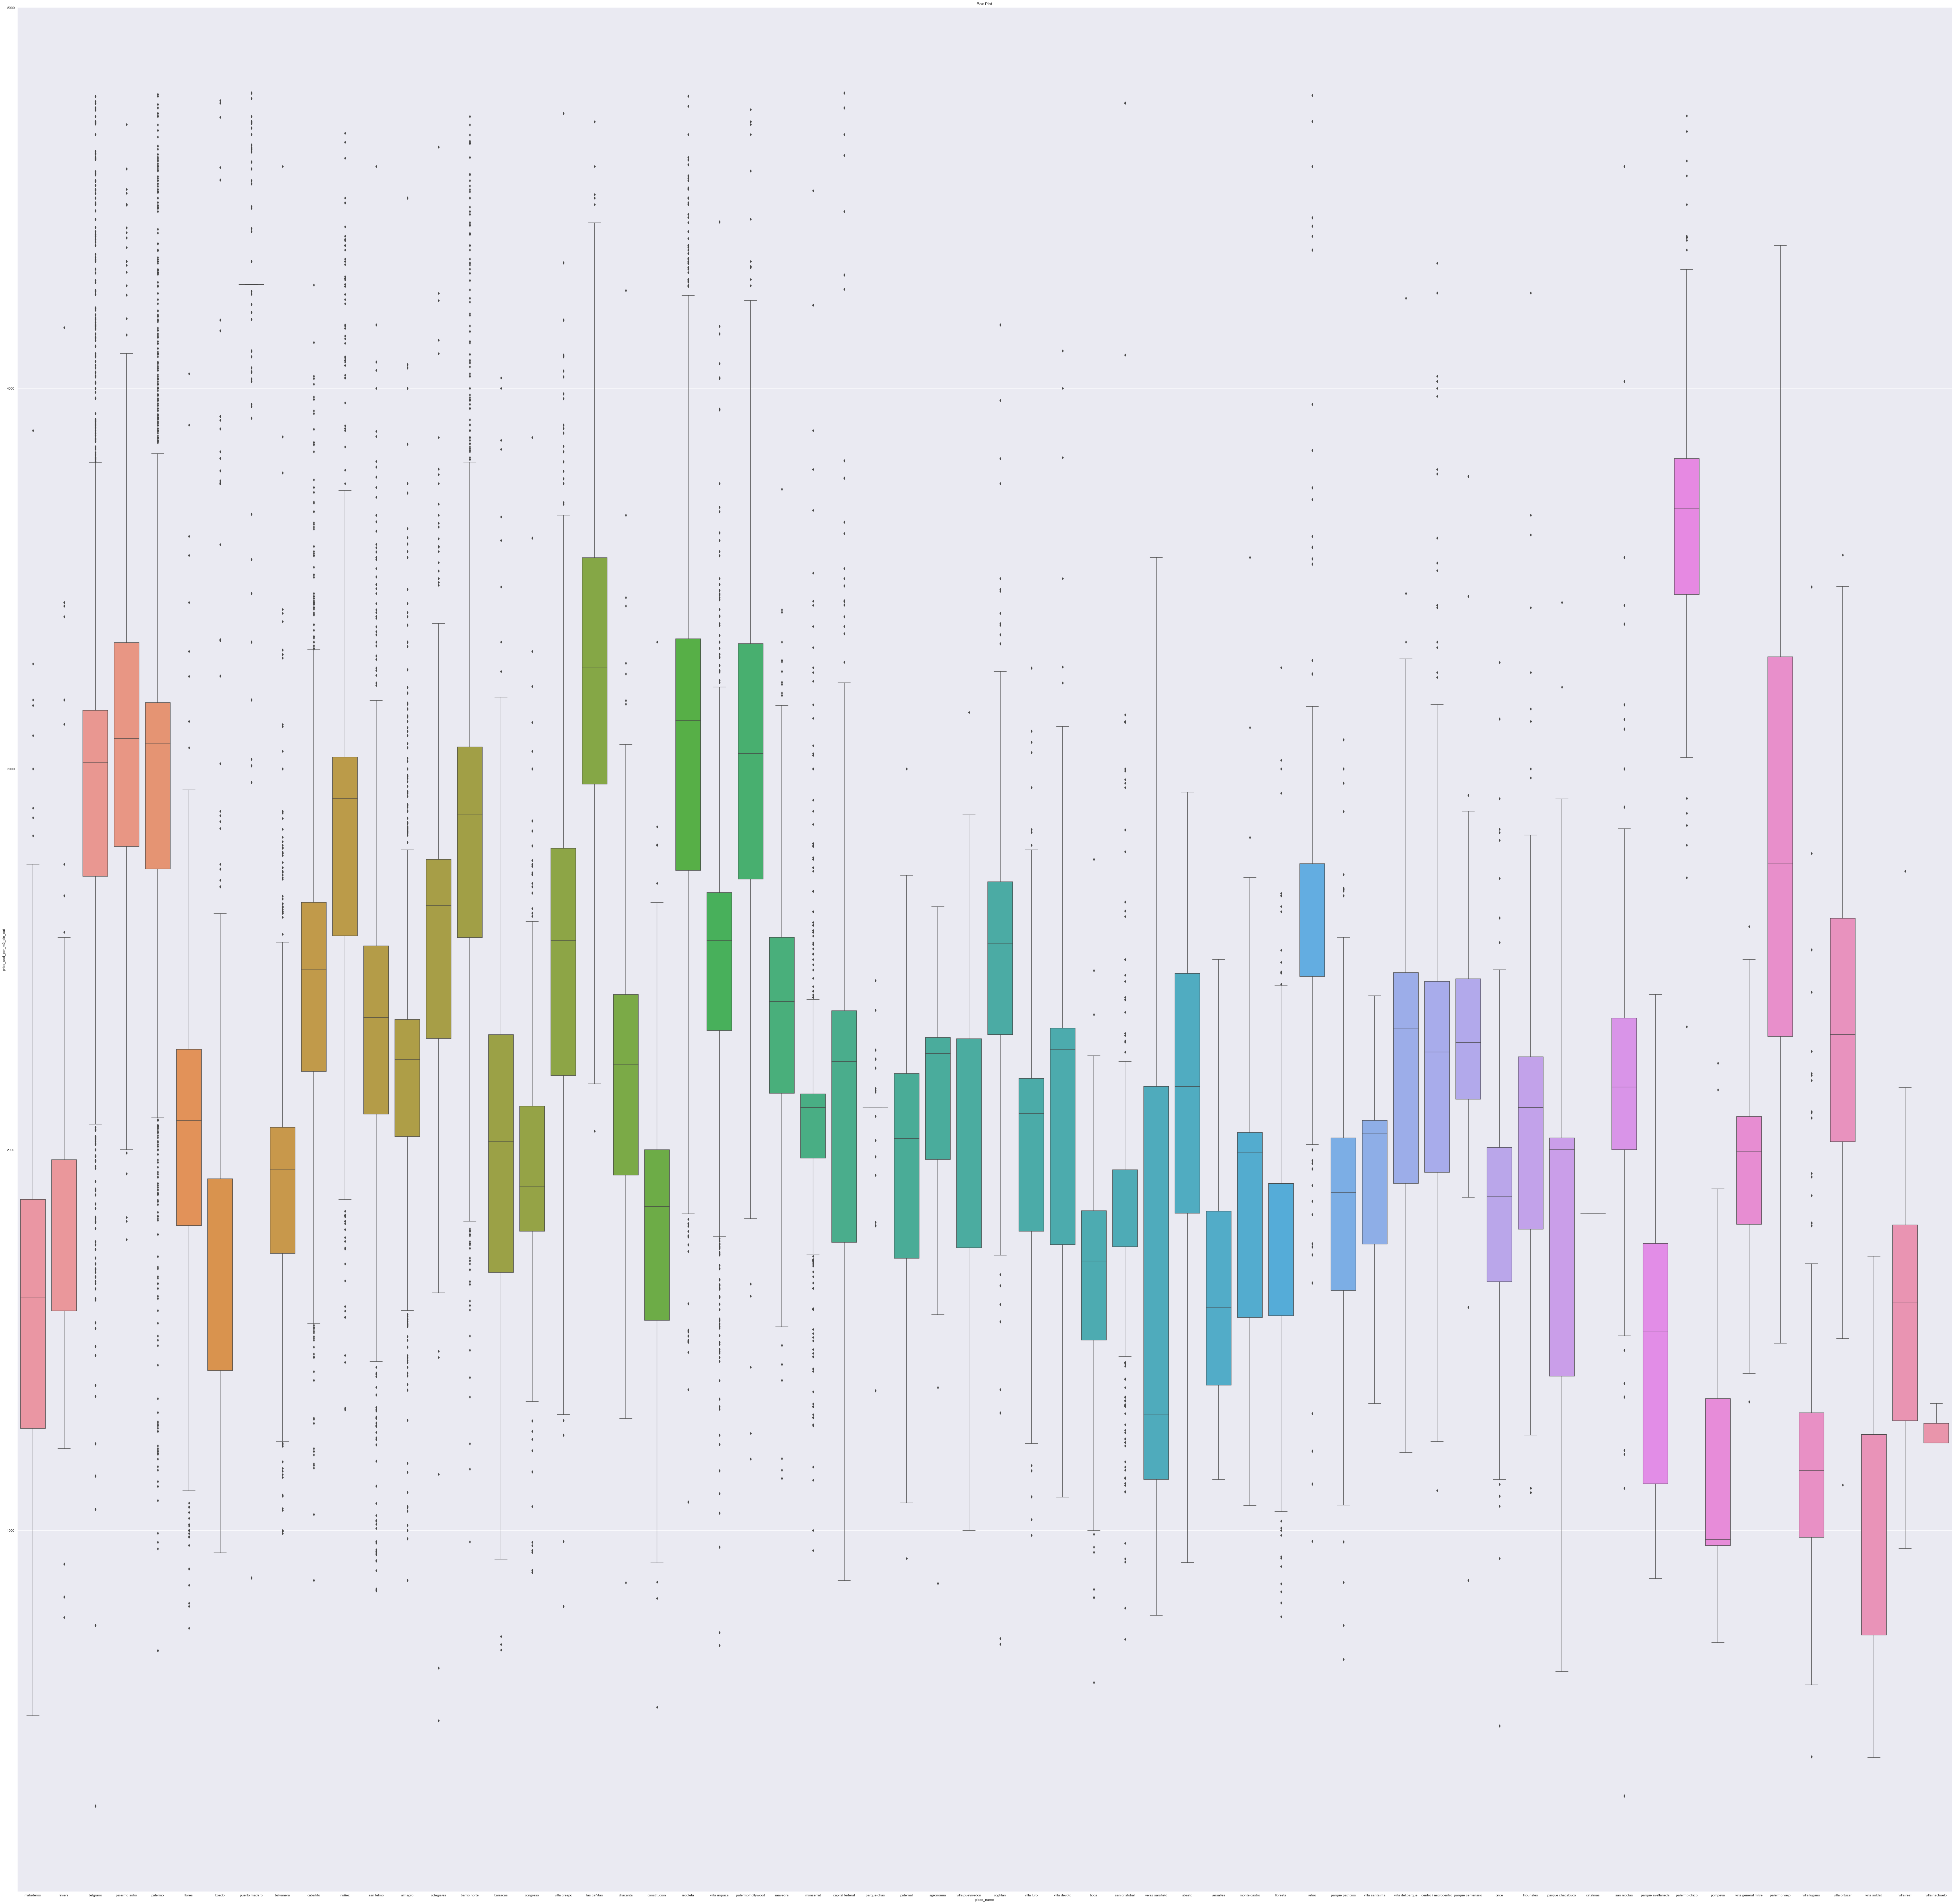

In [45]:
sns.set_style('darkgrid')
plt.figure(figsize=(100,100))
sns.boxplot(data=dfCapi, x="place_name", y="price_m2_sin_out")

plt.xlabel("place_name"); plt.ylabel("price_usd_per_m2_sin_out");plt.title("Box Plot")
plt.show()


- **Relación por tipo de propiedad, precio y superficie**

In [ ]:
# SACAR OUTLIERS DE SUPERFICE

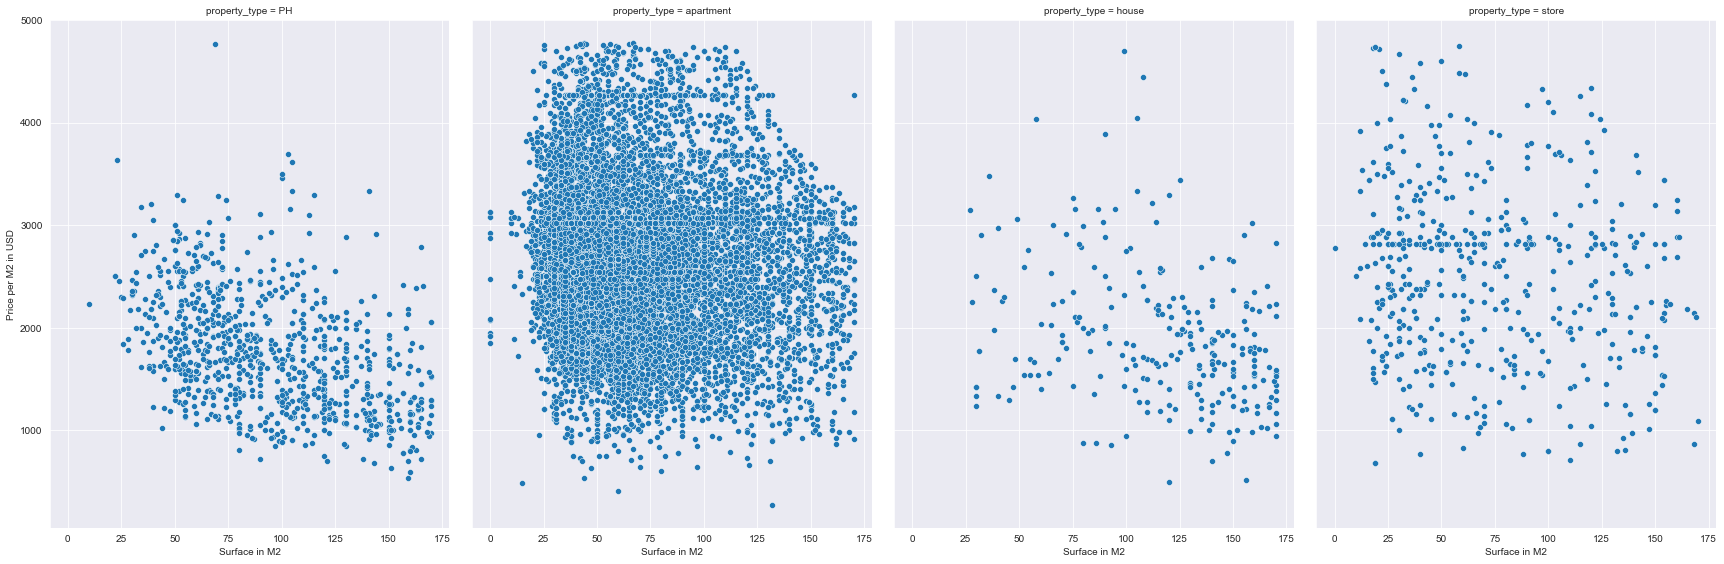

In [46]:
g = sns.FacetGrid(dfCapi, col="property_type")
g.map(sns.scatterplot, "surface_total_in_m2", "price_m2_sin_out")
g.fig.set_size_inches(25, 10)
g.set_axis_labels('Surface in M2', "Price per M2 in USD")
plt.show()

- **Distribución de precio en usd por m2**

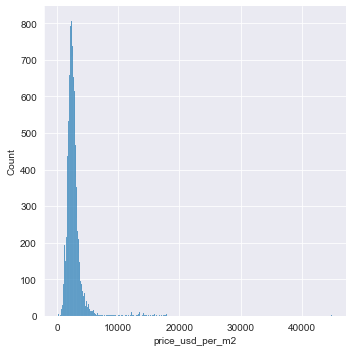

In [47]:
sns.displot(dfCapi['price_usd_per_m2']);

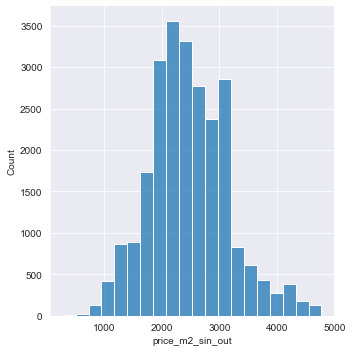

In [48]:
sns.displot(dfCapi['price_m2_sin_out'], bins=20);

- **Boxplot de precio por m2 por tipo de propiedad**

Los departamentos en promedio son más caros que las casas. En general las casas se dan más en barrios más baratos 

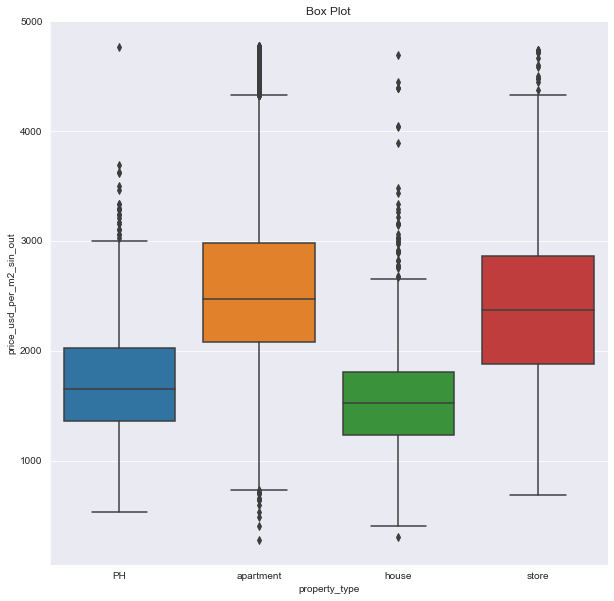

In [49]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
sns.boxplot(data=dfCapi, x="property_type", y="price_m2_sin_out")

plt.xlabel("property_type"); plt.ylabel("price_usd_per_m2_sin_out");plt.title("Box Plot")
plt.show()

In [50]:
dfCapi.loc[:,["property_type","price_m2_sin_out"]].groupby("property_type").agg(["mean","median", "skew"])

price_m2_sin_out                       
                          mean       median      skew
property_type                                        
PH                 1718.336617  1650.000000  0.817685
apartment          2543.533313  2471.897513  0.562249
house              1616.662648  1520.671324  1.573111
store              2425.867825  2374.200402  0.381285

### **3. Creación de nuevos campos**

- Amenities

In [51]:
#Convertimos la columna description en una lista
description_list = list(set(dfCapi['description']))

In [52]:
# Armamos una lista de keywords que nos interesa encontrar en la columna description de cada propiedad
amenities_list = ['parrilla', 'hidromasaje', 'jacuzzi','terraza','cochera', 'solarium', 'baulera', 'balcón', 'patio','patios','sum','salón de usos múltiples','seguridad' ,'mármol', 'gimnasio', 'gym','lavadero','losa radiante','vigilancia','laundry','luminoso','apto profesional',"pileta","piscina"]

In [53]:
#Regex para separar con pipes cada keyword
ame = r'\b(?:{})\b'.format('|'.join(map(re.escape, amenities_list)))

In [54]:
#Ponemos en minuscula las descripciones
dfCapi['description']=dfCapi.description.str.lower()
dfCapi_amenities=dfCapi

In [55]:
#nos fijamos en que descripcion hay algun valor de la lista de amenities
df_amenities = dfCapi_amenities.loc[dfCapi_amenities['description'].str.contains(ame)].reset_index()

In [56]:

df_amenities['aux_split']=df_amenities.description.str.split(' ')

In [57]:
df_amenities.head()

index  Unnamed: 0  Unnamed: 0.1 operation property_type place_name  \
0      0           0             0      sell            PH  mataderos   
1      1           1             2      sell     apartment  mataderos   
2      2           2             3      sell            PH    liniers   
3      3           3             7      sell     apartment   belgrano   
4      4           4             8      sell     apartment   belgrano   

                 place_with_parent_names country_name       state_name  \
0  |Argentina|Capital Federal|Mataderos|    Argentina  Capital Federal   
1  |Argentina|Capital Federal|Mataderos|    Argentina  Capital Federal   
2    |Argentina|Capital Federal|Liniers|    Argentina  Capital Federal   
3   |Argentina|Capital Federal|Belgrano|    Argentina  Capital Federal   
4   |Argentina|Capital Federal|Belgrano|    Argentina  Capital Federal   

   geonames_id  ...                                      properati_url  \
0    3430787.0  ...  http://www.properati.com.ar/15bo8_venta_ph_mat...   
1    3430787.0  ...  http://www.properati.com.ar/15bod_venta_depart...   
2    3431333.0  ...  http://www.properati.com.ar/15boh_venta_ph_lin...   
3    3436077.0  ...  http://www.properati.com.ar/15bot_venta_depart...   
4    3436077.0  ...  http://www.properati.com.ar/15bou_venta_depart...   

                                         description  \
0  2 ambientes tipo casa planta baja por pasillo,...   
1  2 ambientes 3er piso lateral living comedor am...   
2  ph 3 ambientes con patio. hay 3 deptos en lote...   
3  excelente monoambiente a estrenar amplio super...   
4  excelente dos ambientes  estrenar amplio super...   

                                               title  \
0                 2 AMB TIPO CASA SIN EXPENSAS EN PB   
1           2 AMB 3ER PISO CON ASCENSOR APTO CREDITO   
2                       PH 3 amb. cfte. reciclado      
3  JOSE HERNANDEZ 1400 MONOAMBIENTE  ESTRENAR CAT...   
4  JOSE HERNANDEZ   1400 DOS AMBIENTES ESTRENAR ,...   

                                     image_thumbnail rooms_reg  \
0  https://thumbs4.properati.com/8/BluUYiHJLhgIIK...       2.0   
1  https://thumbs4.properati.com/5/SXKr34F_IwG3W_...       2.0   
2  https://thumbs4.properati.com/3/DgIfX-85Mog5SP...       3.0   
3  https://thumbs4.properati.com/1/IHxARynlr8sPEW...       1.0   
4  https://thumbs4.properati.com/2/J3zOjgaFHrkvnv...       2.0   

                          geometry  distancia_subte  price_m2_sin_out  \
0  POINT (-58.5088387 -34.6618237)          4728.39       1127.272727   
1  POINT (-58.5229825 -34.6522615)          6073.15       1309.090909   
2  POINT (-58.5164244 -34.6477969)          5305.63       1497.995186   
3   POINT (-58.443362 -34.5598729)           609.74       3066.666667   
4   POINT (-58.443362 -34.5598729)           609.74       3000.000000   

   cerca_lejos                                          aux_split  
0            0  [2, ambientes, tipo, casa, planta, baja, por, ...  
1            0  [2, ambientes, 3er, piso, lateral, living, com...  
2            0  [ph, 3, ambientes, con, patio., hay, 3, deptos...  
3            0  [excelente, monoambiente, a, estrenar, amplio,...  
4            0  [excelente, dos, ambientes, , estrenar, amplio...  

[5 rows x 34 columns]

In [58]:
ame_name = []
aux_split = []
events = []
for i in range(len(df_amenities['aux_split'])):
    for j in range(len(df_amenities['aux_split'][i])):
        if df_amenities['aux_split'][i][j] in amenities_list:
            ame_name.append(df_amenities['aux_split'][i][j])
            aux_split.append((df_amenities['index'][i]))
            events.append(1)

In [59]:
aux_ame = pd.DataFrame(
    {'aux_split': aux_split,
     'Amenities': ame_name,
     'events':events
    })

In [60]:
aux_ame.head(20)

aux_split  Amenities  events
0           0      patio       1
1           3   luminoso       1
2           3     pileta       1
3           3    laundry       1
4           4   luminoso       1
5           4     pileta       1
6           4    laundry       1
7           5    terraza       1
8           5    piscina       1
9           6    piscina       1
10          8   luminoso       1
11          8     balcón       1
12          8    baulera       1
13          9     patios       1
14         10   luminoso       1
15         10     balcón       1
16         10     balcón       1
17         11     balcón       1
18         11     balcón       1
19         13  seguridad       1

In [61]:
amenities= pd.pivot_table(aux_ame, index=['aux_split'], columns= ['Amenities'])

In [62]:
amenities.columns = amenities.columns.get_level_values(1)

In [63]:
amenities.size

353682

In [64]:
dfCapi['index_original']=dfCapi.index

In [65]:
dfCapi.size

820710

In [66]:

dfCapi= dfCapi.merge(amenities, left_on='index_original', right_on='aux_split', how='left').fillna(0)


In [67]:
df_amenities.drop_duplicates(subset=["index"], inplace=True)

In [68]:
df_amenities

index  Unnamed: 0  Unnamed: 0.1 operation property_type  \
0          0           0             0      sell            PH   
1          1           1             2      sell     apartment   
2          2           2             3      sell            PH   
3          3           3             7      sell     apartment   
4          4           4             8      sell     apartment   
...      ...         ...           ...       ...           ...   
20474  29733       29733        121157      sell     apartment   
20475  29734       29734        121158      sell     apartment   
20476  29735       29735        121160      sell     apartment   
20477  29737       29737        121217      sell     apartment   
20478  29738       29738        121219      sell     apartment   

            place_name                    place_with_parent_names  \
0            mataderos      |Argentina|Capital Federal|Mataderos|   
1            mataderos      |Argentina|Capital Federal|Mataderos|   
2              liniers        |Argentina|Capital Federal|Liniers|   
3             belgrano       |Argentina|Capital Federal|Belgrano|   
4             belgrano       |Argentina|Capital Federal|Belgrano|   
...                ...                                        ...   
20474         belgrano       |Argentina|Capital Federal|Belgrano|   
20475         recoleta       |Argentina|Capital Federal|Recoleta|   
20476         belgrano       |Argentina|Capital Federal|Belgrano|   
20477    villa urquiza  |Argentina|Capital Federal|Villa Urquiza|   
20478  capital federal                |Argentina|Capital Federal|   

      country_name       state_name  geonames_id  ...  \
0        Argentina  Capital Federal    3430787.0  ...   
1        Argentina  Capital Federal    3430787.0  ...   
2        Argentina  Capital Federal    3431333.0  ...   
3        Argentina  Capital Federal    3436077.0  ...   
4        Argentina  Capital Federal    3436077.0  ...   
...            ...              ...          ...  ...   
20474    Argentina  Capital Federal    3436077.0  ...   
20475    Argentina  Capital Federal    3429595.0  ...   
20476    Argentina  Capital Federal    3436077.0  ...   
20477    Argentina  Capital Federal    3433775.0  ...   
20478    Argentina  Capital Federal    3433955.0  ...   

                                           properati_url  \
0      http://www.properati.com.ar/15bo8_venta_ph_mat...   
1      http://www.properati.com.ar/15bod_venta_depart...   
2      http://www.properati.com.ar/15boh_venta_ph_lin...   
3      http://www.properati.com.ar/15bot_venta_depart...   
4      http://www.properati.com.ar/15bou_venta_depart...   
...                                                  ...   
20474  http://www.properati.com.ar/1cj5q_venta_depart...   
20475  http://www.properati.com.ar/1cj5s_venta_depart...   
20476  http://www.properati.com.ar/1cj5v_venta_depart...   
20477  http://www.properati.com.ar/1cja7_venta_depart...   
20478  http://www.properati.com.ar/1cjaa_venta_depart...   

                                             description  \
0      2 ambientes tipo casa planta baja por pasillo,...   
1      2 ambientes 3er piso lateral living comedor am...   
2      ph 3 ambientes con patio. hay 3 deptos en lote...   
3      excelente monoambiente a estrenar amplio super...   
4      excelente dos ambientes  estrenar amplio super...   
...                                                  ...   
20474  torre de 16º pisos ubicado en pleno centro com...   
20475  excelente ubicación - avenida pueyrredon y las...   
20476  edificio en esquina de muy buena categoría de ...   
20477  venta departamento ambiente divisible a estren...   
20478  departamento de 77 m2 apto profesional. edific...   

                                                   title  \
0                     2 AMB TIPO CASA SIN EXPENSAS EN PB   
1               2 AMB 3ER PISO CON ASCENSOR APTO CREDITO   
2                           PH 3 amb. cfte. reciclado      
3      JOSE HERNAN

In [69]:
dfCapi.size

1342980

In [70]:
dfCapi['index_original']

0            0
1            1
2            2
3            3
4            4
         ...  
24865    29733
24866    29734
24867    29735
24868    29737
24869    29738
Name: index_original, Length: 24870, dtype: int64

In [71]:
dfCapi["suma_amenities"] = dfCapi.loc[:,['balcón', 'baulera', 'cochera', 'gimnasio', 'gym',
       'hidromasaje', 'jacuzzi', 'laundry', 'lavadero', 'luminoso', 'mármol',
       'parrilla', 'patio', 'patios', 'seguridad', 'solarium', 'sum',
       'terraza', 'vigilancia', "pileta","piscina"]].sum(axis=1)

In [74]:
# dfCapi.to_csv("final.csv")